In [111]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from IPython.display import display, Markdown, Latex

import numpy as np
import pandas as pd 

import matplotlib.pyplot as plt 
import seaborn as sns
import seaborn.objects as so

sns.set_theme()

# Assignment 4
**Julien ARS** - 07.01.2024

## Task 1 : Natural frequency

We make the following assumptions :
1. We will analyse the bridge under longitudinal flexion
1. We consider that the liaison between the HEM140 on the middle of the bridge is such that it can be considered as a full length HEM140 beam in the longitudinal axis.
1. Any other element than the HEM140 do not have any structural influence on the behaviour of the bridge (considering the connection consisting of 4 bolts is not sufficient to have them take any effort in their secondary axis), except for their weight. In particular, this means we can consider :
$$ EI = \text{const} = 2*EI_{HEM140} $$
4. We modelise the bridge as a beam on two supports, one of which is mobile
5. The weight of the cord is considered to be 0.4 kg/m

Properties of the different elements, as well as of the bridge, are taken from the C5  table.

In order to estimate the natural frequency, we will start with reducing the footbridge as a SDOF system, using the method provided [*Systems with distributed mass*, Aline Bönzli].

In order to do so, we will modelise the mass of the bridge and it's rigidity in python : (using a precision to the milimeter for the computation)

In [112]:
# Properties of steel :
E = 210e3 #N/mm²
rho = 7850 #kg/m³

# Rigidity :
EI = 2 * E * (32.9e6) #N.mm²

In [113]:
# Define coordinates :
# -  x : longitudinal axis (0 at first appui)
x = np.linspace(-300, 10300, 10601)
dx = x[1]-x[0] # mm
# Lambda utility to get the indice from a position:
i = lambda xi : np.argmin(np.abs(x-xi))  # noqa: E731

# Define empty mass array (in x coordinatess)
m = np.zeros_like(x) #kg/mm

print(x, dx, m , i(5000), sep="  -  ")

[ -300.  -299.  -298. ... 10298. 10299. 10300.]  -  1.0  -  [0. 0. 0. ... 0. 0. 0.]  -  5300


In [114]:
# Fill the mass array :

## Longitudinal constant weight : 2*HEM140 + plates of 40 mm x 1m
m[:] = 2*63.2e-3 + (40e-3 * 1 * 1e-3) * rho # kg/mm 

print(m[0])

0.4404


In [115]:
## Transversal elements weight gets transfered to the HEM beams only at the location of the bolts
## Therefore, we will add them as point masses at the center of the bolt
## The transversal elements consist each time of : 
#   - 1* HEA100 x 783 mm
m_HEA100 = 16.7 * 0.783 #kg
#   - 4*FLA 90.20 L=110mm
m_FLA = 14.1 * 0.110 #kg
#   - 2*IPET 180 L=155mm(however, cut in triangle with a triangle of 50x155mm removed)
m_IPE180 = 9.40 *0.155 - (0.050 * 0.155 * 0.0053)/2 * rho #kg
#   - 2*ROR 51.5.0 L=1330 mm
m_ROR = 5.67 * 1.33 #kg
#   - 2*tubes dint=35mm, dext=38mm, L=50mm
m_tubes = (np.pi * ((19e-3)**2 - (17.5e-3)**2) * 50e-3) * rho #kg
#   - 2*rondelles
m_rondelles = (np.pi * (27e-3)**2 * 6e-3) * rho #kg

m_transversal = 1*m_HEA100 + 4*m_FLA + 2*m_IPE180 + 2*m_ROR + 2*m_tubes + 2*m_rondelles

print(m_transversal, m_HEA100, m_FLA, m_IPE180, m_ROR, m_tubes, m_rondelles)

# These transveral elements are present at 6 locations :
x_trans = np.array([0, 2000, 4000, 6000, 8000, 10000]) #mm

# Bolts are present 30 mm from those locations
x_bolts = np.concatenate((x_trans-30, x_trans+30))
print(x_bolts)

# Add the mass from the transversal elements :
m[[i(x) for x in x_bolts]] += m_transversal / 2 / dx #dividing by dx ensures the mass is fully considered, even for dx != 1

37.30462179764926 13.0761 1.551 1.2957806250000001 7.5411 0.0675108626302361 0.10786941119439378
[  -30  1970  3970  5970  7970  9970    30  2030  4030  6030  8030 10030]


In [116]:
# Add the cord's mass
rho_cord = 0.400 #kg/m

# We consider  the poles have all to support 2m of cord, except the poles at the end who supports only 1m
m_cord = 2* rho_cord #kg

x_bolts_2m = np.concatenate((x_trans[1:-1]-30, x_trans[1:-1]+30))
x_bolts_1m = np.concatenate((x_trans[[0,-1]]-30, x_trans[[0,-1]]+30))

m[[i(x) for x in x_bolts_2m]] += m_cord/2 /dx
m[[i(x) for x in x_bolts_1m]] += m_cord/4 /dx

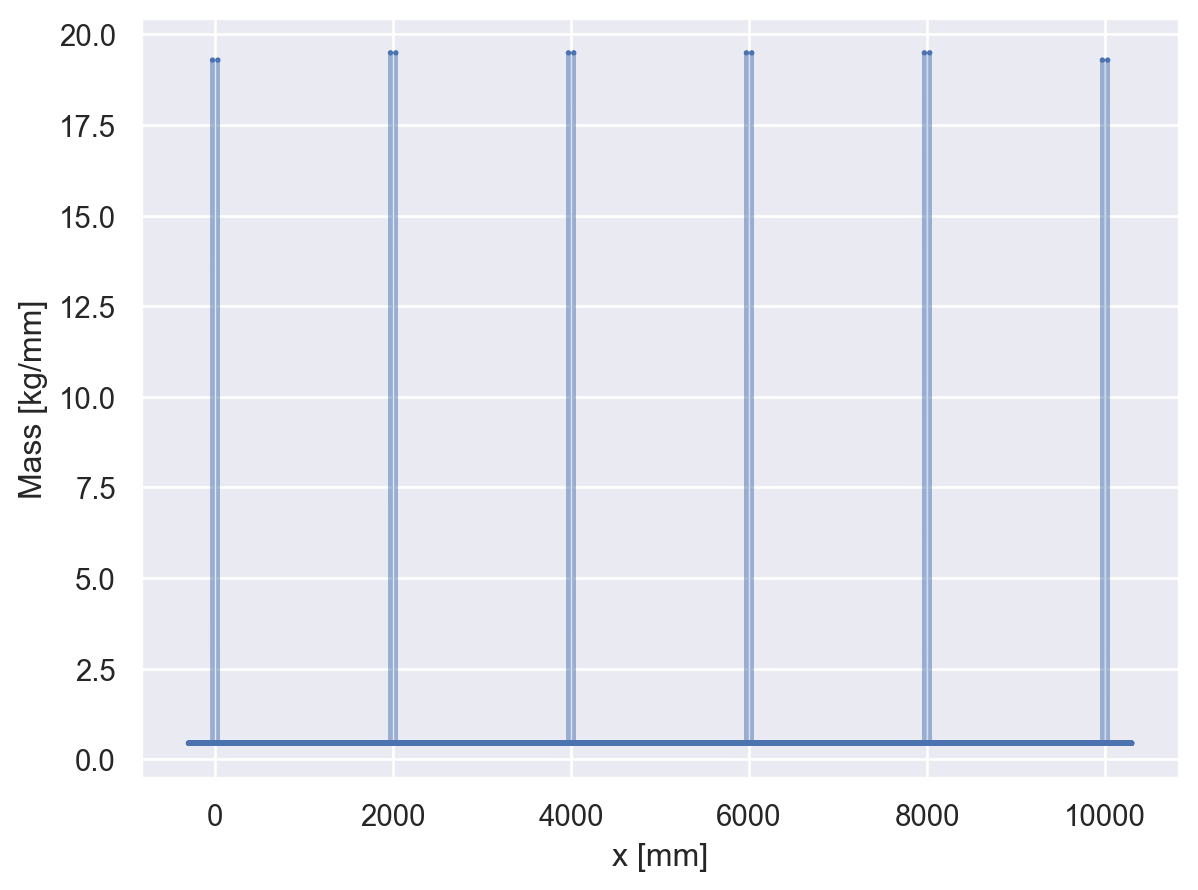

In [117]:
(
    so.Plot(x=x, y=m)
    .add(so.Dot(pointsize=1.5))
    .add(so.Line(alpha=0.5))
    .label(x="x [mm]", y="Mass [kg/mm]")
    .plot()
)

Now that we have the mass, we need to define the bending shape. We will opt for a sine function, which will be equal to 0 at each support ($x = 0 $ and $x = 10000$ [mm]). We consider that outside the supports, the beam will also deform in a sin shape.
$$ \psi(x) = \text{sin}(\frac{x*\pi}{10 \text{ m}}) $$
Which yields :
$$ \psi''(x) = \psi(x) * \left (\frac{\pi}{10 \text{ m}} \right )^2 $$

In [118]:
psi = np.sin(x*np.pi/10000)
psi_pp = psi * (np.pi/10000)**2 # -/mm²

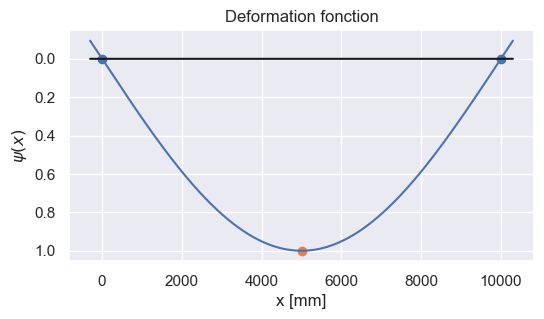

In [119]:
plt.figure(figsize=(6, 3))
plt.plot(x, psi)
plt.plot(x, np.zeros_like(x), c="k")
plt.scatter([0, 10000], [0,0])
plt.scatter(x[i(5000)], psi[i(5000)])
plt.gca().invert_yaxis()
plt.title("Deformation fonction")
plt.xlabel("x [mm]")
plt.ylabel("$\psi(x)$")

plt.show()

**Equivalent mass and stiffness**

Now, we might compute the equivalent mass $m^{*}$ and stiffness $k^{*}$:

$$ m^{*} = \int_{0}^{L} m(x) * \psi^2(x) \text{ d}x $$
$$ k^{*} = EI * \int_{0}^{L} \psi''^2(x) \text{ d}x $$

(considering that there are no normal force in the beam and EI is constant)

In [120]:
# Define integration algorithm

#integrate = np.trapz
integrate = lambda y, dx=1 : y.sum()*dx  # Simpler and sure to include correctly the point masses # noqa: E731

In [121]:
m_star = integrate(m * psi**2, dx=dx) #kg
k_star = EI * integrate(psi_pp**2, dx=dx) *1e3 #N/m

display(Latex(f"$M^{{*}} = {m_star:.0f} \\text{{ kg}}$"))
display(Latex(f"$k^{{*}} = {k_star/1000:.0f}* 10^3\\text{{ N/m}}$"))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

To finilise our reduction of the bridge to a SDOF model, we need to compute the conversion factor for any force acting on the system. Indeed, for a givent acceleration $ü_g$, the equivalent force acting on the system can be considered to be :
$$ q^*(t) = - ü_g(t) * \int_{0}^{L} m(x) * \psi(x) \text{ d}x = - ü_g(t) * \tilde{q}$$

Where $\tilde{q}$ does not depend on the acceleration acting on the system.

In [122]:
q_tilde = np.trapz(m*psi, x=x)
display(Latex(f"$ \\tilde{{q}} = {q_tilde:.0f} \\text{{ kg.mm}}$"))

<IPython.core.display.Latex object>

Now that we have reduced the system to a SDOF model, we can compute the natural period :

$$ \omega_n = \sqrt{\frac{k^*}{m^*}}

In [123]:
omega_n = (k_star/m_star)**0.5
T_n = 2*np.pi / omega_n
f_n = omega_n /2 /np.pi

display(Latex(f"$\\omega_n = {omega_n:.1f}$"))
display(Latex(f"$T_n = \\frac{{2\\pi}}{{\\omega_n}} = {T_n:.2f} \\text{{ s}} $"))
display(Latex(f"$f_n = \\frac{{\\omega_n}}{{2\\pi}} = {f_n:.2f} \\text{{ Hz}}$"))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

## Task 2

We now compute the response of the bridge in two different load cases :
- Load case 1 : A person jumping at the natural frequency
- Load case 2 : A person walking across the bridge

### Load case 1 : A person jumping at the natural frequency (2.72 Hz)

We make the following assumptions : 
1. The person is jumping at the center of the bridge (the point of maximum amplitude of the mode)
2. The damping ratio of the bridge is 2%. This comes from a value cited multiple times in the lesson for steel structures (e.g. Week#10, "Modeling of damping", slide 4 or Week#1, "Introduction", slide 46)

Therefore, we use the following formula (Week#12 of the lesson) to compute the maximum acceleration under this load case :

$$
a_{\max }=\omega_j^2 \cdot y \cdot \alpha \cdot \frac{1}{2 \zeta}
$$

With :
- $\omega_j$ the structural frequency that is in resonance with the forcing function (in this case, $\omega_n$)
- $y$ the static deflection of the bridge at mid-span for the weight $G$ of the person standing at the point of maximum amplitude of the mode. We will take (typical assumption) $G = 700 N$
- $\alpha$ the fourier coefficient of the relevant harmonic. Here, we will take $\alpha = 1.7$, which corresponds to a person jumping at 3 Hz.
- $\zeta$ The damping ratio of the bridge : $\zeta = 0.02$

To compute $y$, the case is a generic one. For a load at the center of a simply supported beam, we have :
$$ y= \frac{GL^3}{48EI} $$

In [139]:
# Data
G = 700 #N
L = 10e3 #mm
damp = 0.02
alpha = 1.7

# Previous results
print(f"EI : {EI:.2e} N.mm² - omega_n : {omega_n:.1f} rad/s")

EI : 1.38e+13 N.mm² - omega_n : 17.1 rad/s


In [140]:
# Computing y :
y = G * L**3 / 48 / EI #mm
display(Latex(f"$y = {y:.2f} \\text{{ mm}}$"))

# Computing a_max
a_max = omega_n**2 *y * alpha /2 /damp *1e-3 #m/s²
display(Latex(f"$a_{{max}} = {a_max:.1f} \\text{{ m/s²}}$"))


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

### Load case 2

For a person walking accross the bridge, we will use a different formula :

$$
a_{\max }=\omega_j^2 \cdot y \cdot \alpha \cdot \phi
$$

Where $\phi$ is a coefficient taking into account the damping, but also the fact that since the person is walking accross the bridge, the number of cycles is limited and the force is not always acting on the most effective point.
This coefficient can be deternined from the following graph [Bachmann H et al. (1997). *Vibration problems in structures: practical guidelines*. Birkhäuser
Verlag, 1995.] : 


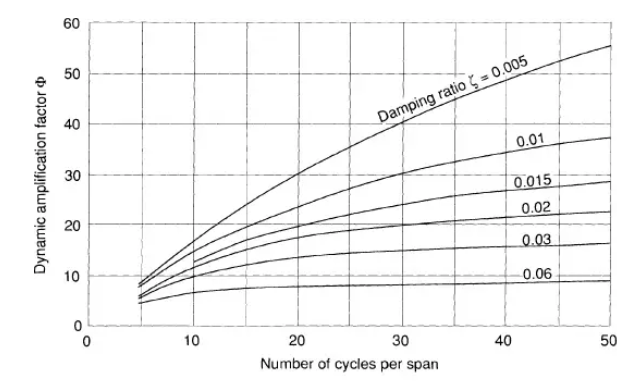

We will consider a footstep length of $0.7 m$ [Bachmann et al. (1997)], which means there will be, for a span of $10 \text{ m}$, $n = \frac{10}{0.7} = 14.3$ cycles per span. For a damping ratio $\zeta = 0.02$, this represents a dynamic amplification factor of $\psi = 14.5$.

We also need to change the fourier coefficient $\alpha$, which for a person walking we will take $\alpha = 0.4$

In [138]:
psi = 14.5
alpha=0.4

# Computing a_max
a_max_2 = omega_n**2 *y*1e-3 * alpha * psi #m/s²
display(Latex(f"$a_{{max, 2}} = {a_max_2:.1f} \\text{{ m/s²}}$"))

<IPython.core.display.Latex object>

**Why is the response due to Load case 2 smaller than for Load case 1 ?**

There are multiple reasons explaining why the response from load case 2 is smaller than the response from load case 1 :
- Firstly, a person walking generates less energy than a person jumping, which explains partly why the response is smaller.
- Secondly, in load case 2 the person is considered to be walking accross the bridge. As such, the person is not always at the most efficient point (the middle of the bridge) and the number of cycles is limited. As such, the steady-state will not be reached.